## Imports and Preliminary

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import models
from torch import Tensor, FloatTensor
from overrides import overrides, final

## Classifiers

In [2]:

class CrossEntropyClassifier():
    _THRESHOLD = 1e-6
    
    def __init__(self, n_classes: int):
        super(CrossEntropyClassifier, self).__init__()
        self.n_classes = n_classes
      
    @final
    def add_threshold(self, prob: Tensor, batch_size: int) -> Tensor:
        zeros = (prob.sum(dim=1) == 0)
        prob_sum = prob.sum(dim=1)
        if torch.any(zeros).item(): 
            thre_tensor = torch.zeros(batch_size)
            thre_tensor[zeros] = self._THRESHOLD
            prob_sum += thre_tensor
        return prob_sum
      
    @final
    def preprocess(self, input: Tensor, split=False, take_first=True) -> Tensor:
        batch_size = input.size(0)
        prob = F.softmax(input, dim=1)
        fw_prob = prob if not split else (prob[:,:self.n_classes] if take_first else prob[:,self.n_classes:])
        return self.add_threshold(fw_prob, batch_size)
      
    @final
    def cross_entropy_loss(self, prob_sum: Tensor):
        return -(prob_sum.log().mean())

class SourceClassifier(CrossEntropyClassifier):
    def __init__(self, n_classes: int):
        super(SourceClassifier, self).__init__(n_classes)
        
    #@overrides
    def forward(self, input: Tensor):
        prob_sum = self.preprocess(input, split=True, take_first=True)
        return self.cross_entropy_loss(prob_sum)
    
class TargetClassifier(CrossEntropyClassifier):
    def __init__(self, n_classes: int):
        super(TargetClassifier, self).__init__(n_classes)
        
    #@overrides
    def forward(self, input: Tensor):
        prob_sum = self.preprocess(input, split=True, take_first=False)
        return self.cross_entropy_loss(prob_sum)

In [3]:
import math
import torch.utils.model_zoo as model_zoo

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(torch.nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = torch.nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.conv3 = torch.nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(planes * 4)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = torch.nn.AvgPool2d(7)
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(args, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=args.num_classes)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    # modify the structure of the model.
    num_of_feature_map = model.fc.in_features
    model.fc = torch.nn.Linear(num_of_feature_map, args.num_classes * 2)
    # model.fc.weight.data.normal_(0.0, 0.02)
    # model.fc.bias.data.normal_(0)
    return model

class TestArgs:
    def __init__(self, pretrained, num_classes):
        self.pretrained = pretrained
        self.num_classes = num_classes

In [9]:

def feature_extractor(model='resnet18'):
    if model == 'resnet18': 
        model =  resnet18(TestArgs(True, 1000)) # models.resnet18(pretrained=True)
    elif model == 'resnet50': 
        model = models.resnet50(pretrained=True)
    else:
        raise ValueError('Unknown model')
    return model # torch.nn.Sequential(*list(model.children())[:-1])

In [10]:
with open('docs/resnet18_symnets.txt', 'w') as f:
    f.write(feature_extractor().__str__())

In [11]:
# torch.nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1])
model = models.resnet18(pretrained=True)
with open('docs/resnet18_online.txt', 'w') as f:
    f.write(model.__str__())

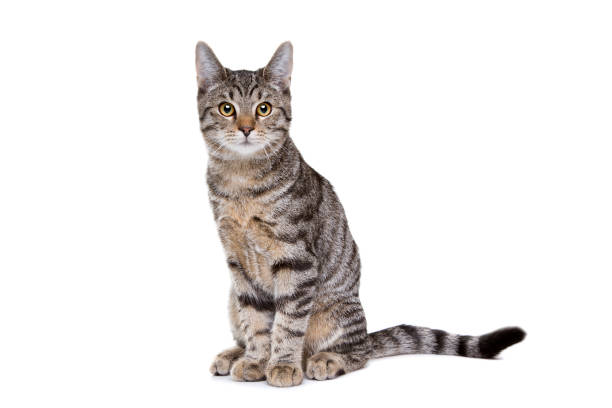

In [6]:
# Load the image
from PIL import Image
img_cat = Image.open("cat.jpeg").convert('RGB')
img_cat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


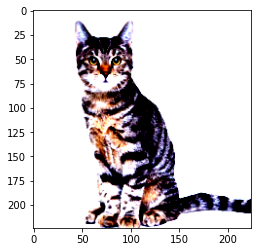

In [7]:
from torchvision import transforms
#
# Create a preprocessing pipeline
#
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
#
# Pass the image for preprocessing and the image preprocessed
#
img_cat_preprocessed = preprocess(img_cat)
plt.imshow(img_cat_preprocessed.permute(1, 2, 0))
plt.show()

In [8]:
#
# Reshape, crop, and normalize the input tensor for feeding into network for evaluation
#
batch_img_cat_tensor = torch.unsqueeze(img_cat_preprocessed, 0)
print(batch_img_cat_tensor.shape)

torch.Size([1, 3, 224, 224])


In [12]:
#
# Resnet is required to be put in evaluation mode in order
# to do prediction / evaluation
#
resnet = feature_extractor(model='resnet18')
# resnet.eval()
#
# Get the predictions of image as scores related to how the loaded image
# matches with 1000 ImageNet classes. The variable, out is a vector of 1000 scores
#
out = resnet(batch_img_cat_tensor)
print(out.shape)
print(out)

torch.Size([1, 2000])
tensor([[ 0.3026,  0.8187, -0.9804,  ..., -0.5183, -0.8307, -0.4974]],
       grad_fn=<AddmmBackward0>)


In [ ]:

# out = torch.zeros(2, 3) # input of a tensor of zeroes 

# cl = SourceClassifier(1)
# cl.forward(out) # in uscita abbiamo un tensore con LOSS, grad_fn

n_classes = 1000

def add_threshold(prob: Tensor, batch_size: int):
    zeros = (prob.sum(dim=1) == 0)
    prob_sum = prob.sum(dim=1)
    if any(zeros): 
        thre_tensor = torch.zeros(batch_size)
        thre_tensor[zeros] = 1e-6
        prob_sum += thre_tensor
    return prob_sum
      
def preprocess_tensor(input: Tensor, split=False, take_first=True):
    batch_size = input.size(0)
    prob = F.softmax(input, dim=1)
    fw_prob = prob if not split else (prob[:,:n_classes] if take_first else prob[:,n_classes:])
    return add_threshold(fw_prob, batch_size)

def cross_entropy_loss(prob_sum: Tensor):
    return -(prob_sum.log().mean())

prob_sum = preprocess_tensor(out, split=True, take_first=True)
print(cross_entropy_loss(prob_sum))